In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import requests
import pysal as ps
from pysal.viz import mapclassify
import palettable as pltt
from seaborn import palplot
import zipfile
import folium  

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.use('TkAgg')
%matplotlib inline

In [2]:
nodes = gpd.read_file('santander_nodes.shp')

In [3]:
nodes.head()

local                       official_n official_r       lon  \
0        Hoxton          Windsor Terrace, Hoxton         30 -0.093388   
1  King's Cross       Pancras Road, King's Cross         34 -0.129244   
2   Clerkenwell       Ampton Street, Clerkenwell         26 -0.118235   
3    St. Luke's          Bath Street, St. Luke's        119 -0.090836   
4  King's Cross  St. Chad's Street, King's Cross          4 -0.121057   

         lat                   geometry  
0  51.529125  POINT (-0.09339 51.52913)  
1  51.534038  POINT (-0.12924 51.53404)  
2  51.527292  POINT (-0.11824 51.52729)  
3  51.525828  POINT (-0.09084 51.52583)  
4  51.530015  POINT (-0.12106 51.53002)

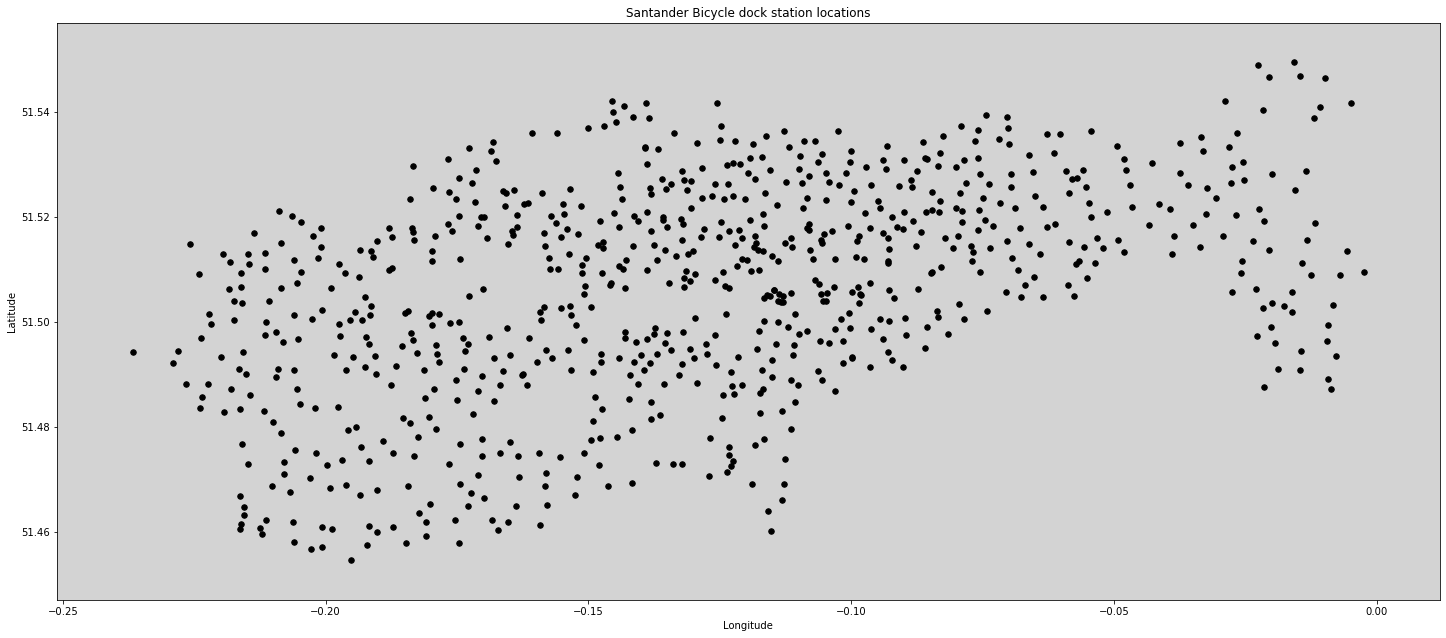

In [46]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,20))
ax.set_facecolor('lightgrey')

# Plot santander
nodes.plot(ax=ax, color='black', markersize=30)

plt.tight_layout()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Santander Bicycle dock station locations')
plt.savefig('santander_bike_shp.png')
plt.show()

In [5]:
nodes.dtypes

local           object
official_n      object
official_r      object
lon            float64
lat            float64
geometry      geometry
dtype: object

In [6]:
#Turn official_r object into integer type
nodes["official_r"]=nodes["official_r"].astype(int)

In [7]:
nodes.dtypes

local           object
official_n      object
official_r       int64
lon            float64
lat            float64
geometry      geometry
dtype: object

In [8]:
#Create position dataframe to be used to create a position dictionary for network nodes
pos_df = nodes[['official_r', 'lon', 'lat']]
pos_df.head(10)

official_r       lon        lat
0          30 -0.093388  51.529125
1          34 -0.129244  51.534038
2          26 -0.118235  51.527292
3         119 -0.090836  51.525828
4           4 -0.121057  51.530015
5         204 -0.112325  51.526649
6         331 -0.089885  51.520860
7         403 -0.158436  51.516885
8          18 -0.122162  51.514738
9         405 -0.182531  51.494164

In [9]:
#Total of positions
sorted(pos_df['official_r'].unique())
len(pos_df['official_r'].unique())

791

In [10]:
#Load in edge data as prepared in 'Network Analysis CW2 - data prep.ipynb'
short_journey_edges = pd.read_csv('short_journeys.csv')
commuter_journey_edges = pd.read_csv('commuter_journeys.csv')
long_journey_edges = pd.read_csv('long_journeys.csv')
day_journey_edges = pd.read_csv('day_journeys.csv')
multiday_journey_edges = pd.read_csv('multiday_journeys.csv')
all_journey_edges = pd.read_csv('all_journeys.csv')

In [11]:
long_journey_edges.head()

Unnamed: 0  StartStation Id  EndStation Id  count
0           0                1              1      2
1           1                1             64      1
2           2                1            189      2
3           3                1            263      1
4           4                1            661      1

In [12]:
#Get rid of edges that have the same source and target to eliminate loops
short_journey_edges_noself = short_journey_edges.query("`StartStation Id` != `EndStation Id`")
commuter_journey_edges_noself = commuter_journey_edges.query("`StartStation Id` != `EndStation Id`")
long_journey_edges_noself = long_journey_edges.query("`StartStation Id` != `EndStation Id`")
day_journey_edges_noself = day_journey_edges.query("`StartStation Id` != `EndStation Id`")
multiday_journey_edges_noself = multiday_journey_edges.query("`StartStation Id` != `EndStation Id`")
all_journey_edges_noself = all_journey_edges.query("`StartStation Id` != `EndStation Id`")

In [13]:
short_journey_edges_noself = short_journey_edges_noself.drop('Unnamed: 0', axis = 1)
commuter_journey_edges_noself = commuter_journey_edges_noself.drop('Unnamed: 0', axis = 1)
long_journey_edges_noself = long_journey_edges_noself.drop('Unnamed: 0', axis = 1)
day_journey_edges_noself = day_journey_edges_noself.drop('Unnamed: 0', axis = 1)
multiday_journey_edges_noself = multiday_journey_edges_noself.drop('Unnamed: 0', axis = 1)
all_journey_edges_noself = all_journey_edges_noself.drop('Unnamed: 0', axis = 1)

In [14]:
short_journey_edges_noself.head()

StartStation Id  EndStation Id  count
1                1              3      3
2                1              4      2
3                1              9      2
4                1             11      4
5                1             12     10

In [15]:
#Count how many different journeys of each journey type were made in May, as well as total number of 
#journeys of each type

print ("Short Journey Summary")
print (len(short_journey_edges_noself))
print (short_journey_edges_noself['count'].sum())
print ("\nCommuter Journey Summary")
print (len(commuter_journey_edges_noself))
print (commuter_journey_edges_noself['count'].sum())
print ("\nLong Journey Summary")
print (len(long_journey_edges_noself))
print (long_journey_edges_noself['count'].sum())
print ("\nDay Journey Summary")
print (len(day_journey_edges_noself))
print (day_journey_edges_noself['count'].sum())
print ("\nMultiday Journey Summary")
print (len(multiday_journey_edges_noself))
print (multiday_journey_edges_noself['count'].sum())
print ("\nAll Journeys Summary")
print (len(all_journey_edges_noself))
print (all_journey_edges_noself['count'].sum())

Short Journey Summary
97866
555002

Commuter Journey Summary
138550
380947

Long Journey Summary
12421
24726

Day Journey Summary
391
450

Multiday Journey Summary
175
178

All Journeys Summary
192721
961303


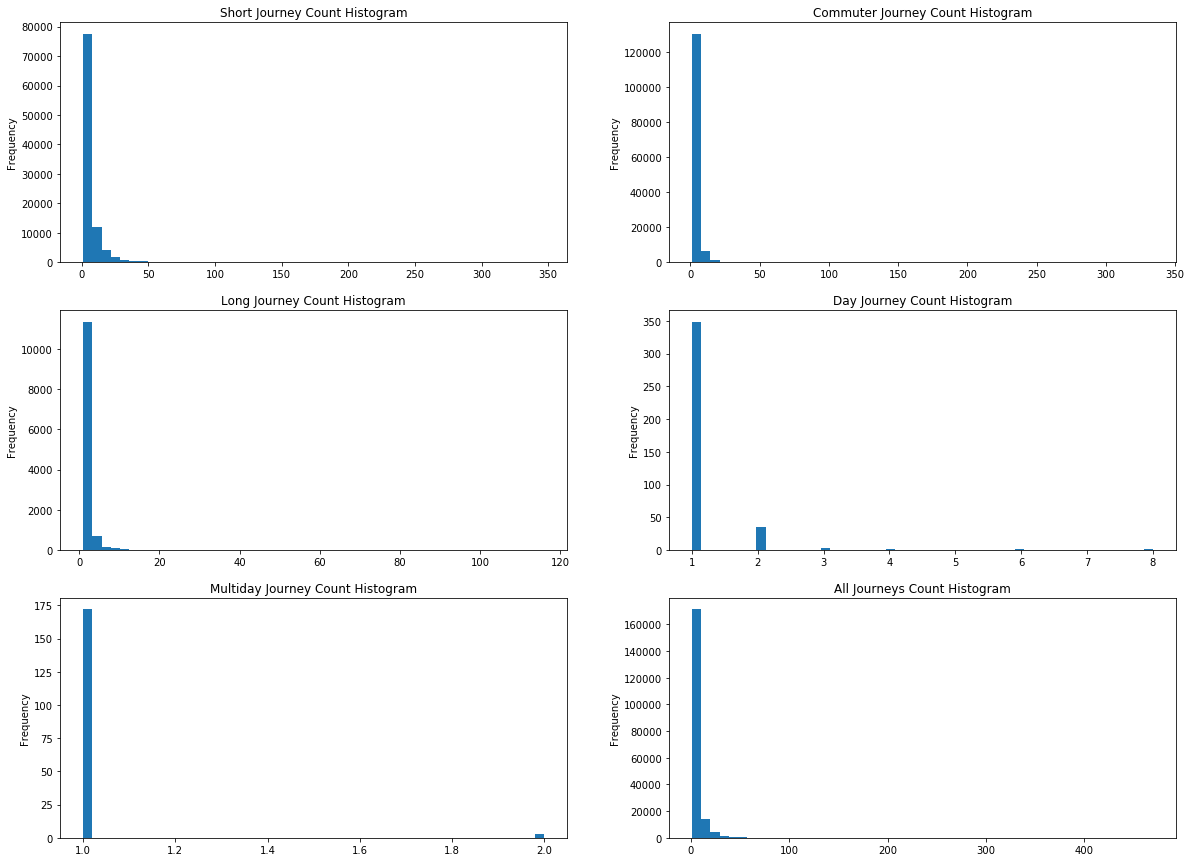

In [16]:
#Plot histograms of count values in order to understand their spread for further network visualization

import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
plt.subplot(3,2,1)
plt.hist(short_journey_edges_noself['count'], bins=50)
plt.gca().set(title='Short Journey Count Histogram', ylabel='Frequency');
plt.subplot(3,2,2)
plt.hist(commuter_journey_edges_noself['count'], bins=50)
plt.gca().set(title='Commuter Journey Count Histogram', ylabel='Frequency');
plt.subplot(3,2,3)
plt.hist(long_journey_edges_noself['count'], bins=50)
plt.gca().set(title='Long Journey Count Histogram', ylabel='Frequency');
plt.subplot(3,2,4)
plt.hist(day_journey_edges_noself['count'], bins=50)
plt.gca().set(title='Day Journey Count Histogram', ylabel='Frequency');
plt.subplot(3,2,5)
plt.hist(multiday_journey_edges_noself['count'], bins=50)
plt.gca().set(title='Multiday Journey Count Histogram', ylabel='Frequency');
plt.subplot(3,2,6)
plt.hist(all_journey_edges_noself['count'], bins=50)
plt.gca().set(title='All Journeys Count Histogram', ylabel='Frequency');
plt.show()

In [17]:
#Calculate the 97.5th percentile of each journey count in order to use it as the maximum value in the colourmap 
#gradient (edge_vmax attribute in plot)

import numpy as np

qa975 = np.percentile(all_journey_edges_noself['count'], 97.5)
print (qa975)
qs975 = np.percentile(short_journey_edges_noself['count'], 97.5)
print (qs975)
qc975 = np.percentile(commuter_journey_edges_noself['count'], 97.5)
print (qc975)
ql975 = np.percentile(long_journey_edges_noself['count'], 97.5)
print (ql975)
qd975 = np.percentile(day_journey_edges_noself['count'], 97.5)
print (qd975)
qm975 = np.percentile(multiday_journey_edges_noself['count'], 97.5)
print (qm975)

24.0
27.0
12.0
6.0
2.0
1.0


In [18]:
#create weighted directed graphs
import networkx as nx

short_graph = nx.from_pandas_edgelist(short_journey_edges_noself, source = 'StartStation Id', target = 'EndStation Id', edge_attr = 'count', create_using = nx.DiGraph())
commuter_graph = nx.from_pandas_edgelist(commuter_journey_edges_noself, source = 'StartStation Id', target = 'EndStation Id', edge_attr = 'count', create_using = nx.DiGraph())
long_graph = nx.from_pandas_edgelist(long_journey_edges_noself, source = 'StartStation Id', target = 'EndStation Id', edge_attr = 'count', create_using = nx.DiGraph())
day_graph = nx.from_pandas_edgelist(day_journey_edges_noself, source = 'StartStation Id', target = 'EndStation Id', edge_attr = 'count', create_using = nx.DiGraph())
multiday_graph = nx.from_pandas_edgelist(multiday_journey_edges_noself, source = 'StartStation Id', target = 'EndStation Id', edge_attr = 'count', create_using = nx.DiGraph())
graph = nx.from_pandas_edgelist(all_journey_edges_noself, source = 'StartStation Id', target = 'EndStation Id', edge_attr = 'count', create_using = nx.DiGraph())

In [19]:
#turn position dataframe into dictionary in order to be used in visualization

pos = pos_df.set_index('official_r').T.to_dict('list')
pos

{30: [-0.0933878, 51.5291251],
 34: [-0.1292443, 51.5340382],
 26: [-0.1182352, 51.5272918],
 119: [-0.090836, 51.5258279],
 4: [-0.1210572, 51.5300153],
 204: [-0.1123251, 51.5266494],
 331: [-0.0898853, 51.52086],
 403: [-0.1584358, 51.5168848],
 18: [-0.122162, 51.514738],
 405: [-0.1825313, 51.4941642],
 125: [-0.0945159, 51.5006193],
 126: [-0.0963747, 51.5178026],
 102: [-0.0767664, 51.5132843],
 115: [-0.0735754, 51.5141203],
 202: [-0.0694099, 51.5122499],
 294: [-0.1356287, 51.4882685],
 269: [-0.0898251, 51.5008135],
 114: [-0.1588801, 51.5244836],
 85: [-0.0785684, 51.5005614],
 278: [-0.0795057, 51.5034278],
 94: [-0.0859437, 51.4950715],
 9: [-0.0964056, 51.5074778],
 263: [-0.0806186, 51.5141598],
 87: [-0.0796248, 51.5164062],
 217: [-0.0821208, 51.5160656],
 36: [-0.184889, 51.501711],
 404: [-0.1843794, 51.5020106],
 128: [-0.1854649, 51.4954399],
 24: [-0.1246918, 51.5191205],
 13: [-0.1358641, 51.5199711],
 335: [-0.1207367, 51.5119412],
 12: [-0.1304273, 51.5217081]

In [20]:
#Manually update some positions that were missing. The coordinates were manually found using Google Maps.

pos.update( {305 : [-0.1184, 51.4871]} )
pos.update( {259 : [-0.154029, 51.491575]} )
pos.update( {591 : [-0.224229, 51.506171]} )
pos.update( {753 : [-0.234109, 51.491504]} )
pos.update( {788 : [-0.0201, 51.5444]} )
pos.update( {474 : [-0.011463, 51.498198]} )


In [21]:
len(pos)

797

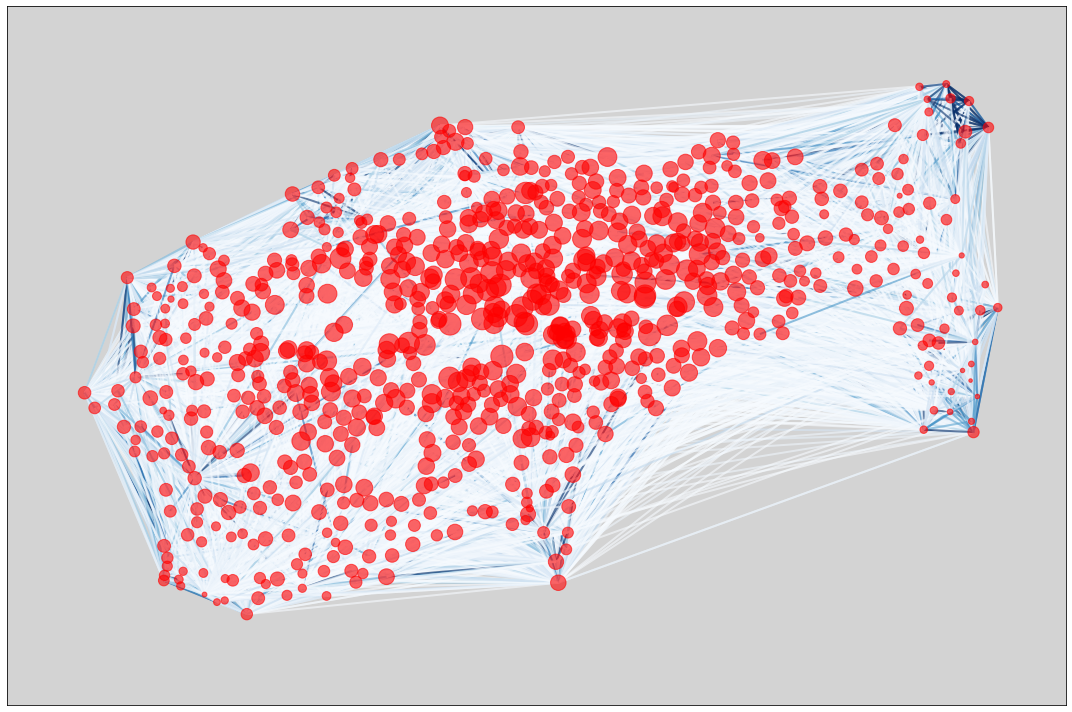

In [34]:
#ALL JOURNEYS NETWORK

import matplotlib.pyplot as plt
import math

degrees = dict(graph.degree)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('lightgrey')
nx.draw_networkx_nodes(G = graph, pos = pos, node_list = graph.nodes(), node_size=[(v-51)*0.5 for v in degrees.values()], node_color = 'r', alpha = 0.6) 
edges,weights = zip(*nx.get_edge_attributes(graph,'count').items())
nx.draw_networkx_edges(G = graph, pos = pos, edge_color=weights, arrows = False, edge_cmap=plt.cm.Blues, edge_vmax = qa975, width = 2, alpha = 0.6)
plt.tight_layout()
plt.savefig('all_journeys.png')
plt.show()

In [26]:
#Import dataframe to link station id with its name

id_to_name = pd.read_csv('id_to_name.csv')
id_to_name.head()

station_id                        station_name
0         446            York Hall, Bethnal Green
1         578    Hollybush Gardens, Bethnal Green
2          40       Commercial Street, Shoreditch
3          39  Shoreditch High Street, Shoreditch
4         401           Columbia Road, Shoreditch

In [24]:
#get in and out degrees

all_out = list(graph.out_degree(graph.nodes()))
all_in = list(graph.in_degree(graph.nodes()))

In [27]:
#Turn degree lists into dataframes, merge with ID to Name dataframe to find the top 10 nodes in terms of degree centrality

all_out_df = pd.DataFrame(all_out, columns=['station_id', 'out_degree'])
all_in_df = pd.DataFrame(all_in, columns=['station_id', 'in_degree'])
all_in_df = all_in_df.merge(id_to_name, on='station_id', how='left')
all_out_df = all_out_df.merge(id_to_name, on='station_id', how='left')
all_in_df.drop(70, inplace = True) #duplicate value, dropped
all_out_df.drop(70, inplace = True)
all_in_df.sort_values(by=['in_degree'], ascending=False).head(10)

station_id  in_degree                     station_name
99          194        535        Hop Exchange, The Borough
195         541        534      Green Park Station, Mayfair
354         341        530            Craven Street, Strand
71          109        525                Soho Square, Soho
316         229        521          Whitehall Place, Strand
232         762        521       Storey's Gate, Westminster
38           64        511        William IV Street, Strand
315         228        505  St. James's Square, St. James's
41           66        503          Holborn Circus, Holborn
163         386        489                Moor Street, Soho

In [28]:
all_out_df.sort_values(by=['out_degree'], ascending=False).head(10)

station_id  out_degree                     station_name
71          109         525                Soho Square, Soho
354         341         515            Craven Street, Strand
232         762         514       Storey's Gate, Westminster
99          194         507        Hop Exchange, The Borough
163         386         506                Moor Street, Soho
195         541         498      Green Park Station, Mayfair
503         826         498       Allington Street, Victoria
271         116         497   Little Argyll Street, West End
67          101         495             Queen Street 1, Bank
315         228         493  St. James's Square, St. James's

In [29]:
graph_ud = graph.to_undirected()
print (nx.average_clustering(graph_ud))

0.6299745129647826


In [30]:
import networkx as nx
Gc = max(nx.connected_components(graph_ud), key=len)

In [31]:
#Centralities not working for some reason, I tried reinstalling anaconda and networkx but couldn't fix the problem
#I wanted to find the centrality of all the networks and compare them, unfortunately I did not manage

# Betweenness centrality
bet_cen = nx.betweenness_centrality(Gc)
# Closeness centrality
clo_cen = nx.closeness_centrality(Gc)
# Eigenvector centrality
eig_cen = nx.eigenvector_centrality(Gc)

AttributeError: 'set' object has no attribute 'is_directed'

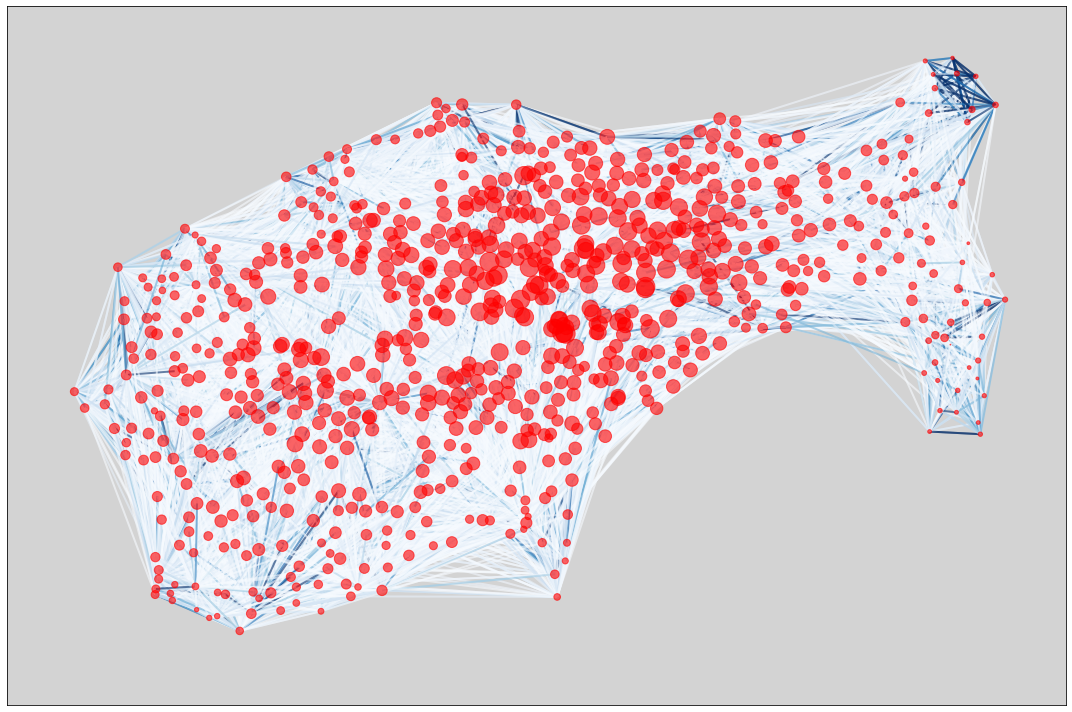

In [35]:
#SHORT JOURNEY NETWORK

import matplotlib.pyplot as plt
import math

short_degrees = dict(short_graph.degree)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('lightgrey')
nx.draw_networkx_nodes(G = short_graph, pos = pos, node_list = short_graph.nodes(), node_size=[(v-20)*0.7 for v in short_degrees.values()], node_color = 'r', alpha = 0.6) 
short_edges,short_weights = zip(*nx.get_edge_attributes(short_graph,'count').items())
nx.draw_networkx_edges(G = short_graph, pos = pos, edge_color=short_weights, arrows = False, edge_cmap=plt.cm.Blues, edge_vmax = qs975, width = 2, alpha = 0.6)
plt.tight_layout()
plt.savefig('short_journeys.png')
plt.show()

In [181]:
short_out = list(short_graph.out_degree(short_graph.nodes()))
short_in = list(short_graph.in_degree(short_graph.nodes()))

In [184]:
short_out_df = pd.DataFrame(short_out, columns=['station_id', 'out_degree'])
short_in_df = pd.DataFrame(short_in, columns=['station_id', 'in_degree'])
short_in_df = short_in_df.merge(id_to_name, on='station_id', how='left')
short_out_df = short_out_df.merge(id_to_name, on='station_id', how='left')
short_in_df.drop([59, 44], inplace = True) #duplicate nodes
short_out_df.drop([59, 44], inplace = True)
short_in_df.sort_values(by=['in_degree'], ascending=False).head(10)

station_id  in_degree                       station_name
118         374        301       Waterloo Station 1, Waterloo
37           66        294            Holborn Circus, Holborn
71          154        279       Waterloo Station 3, Waterloo
328         194        268          Hop Exchange, The Borough
56          101        266               Queen Street 1, Bank
58          109        264                 Soho Square , Soho
82          217        263  Wormwood Street, Liverpool Street
123         427        262                    Cheapside, Bank
43           71        261        Newgate Street , St. Paul's
402          64        260          William IV Street, Strand

In [185]:
short_out_df.sort_values(by=['out_degree'], ascending=False).head(10)

station_id  out_degree                       station_name
58          109         283                 Soho Square , Soho
118         374         269       Waterloo Station 1, Waterloo
82          217         265  Wormwood Street, Liverpool Street
123         427         264                    Cheapside, Bank
37           66         262            Holborn Circus, Holborn
71          154         260       Waterloo Station 3, Waterloo
43           71         257        Newgate Street , St. Paul's
120         386         256                  Moor Street, Soho
481         341         254              Craven Street, Strand
56          101         250               Queen Street 1, Bank

In [221]:
short_graph_ud = short_graph.to_undirected()
print (nx.average_clustering(short_graph_ud))

0.6203700889646309


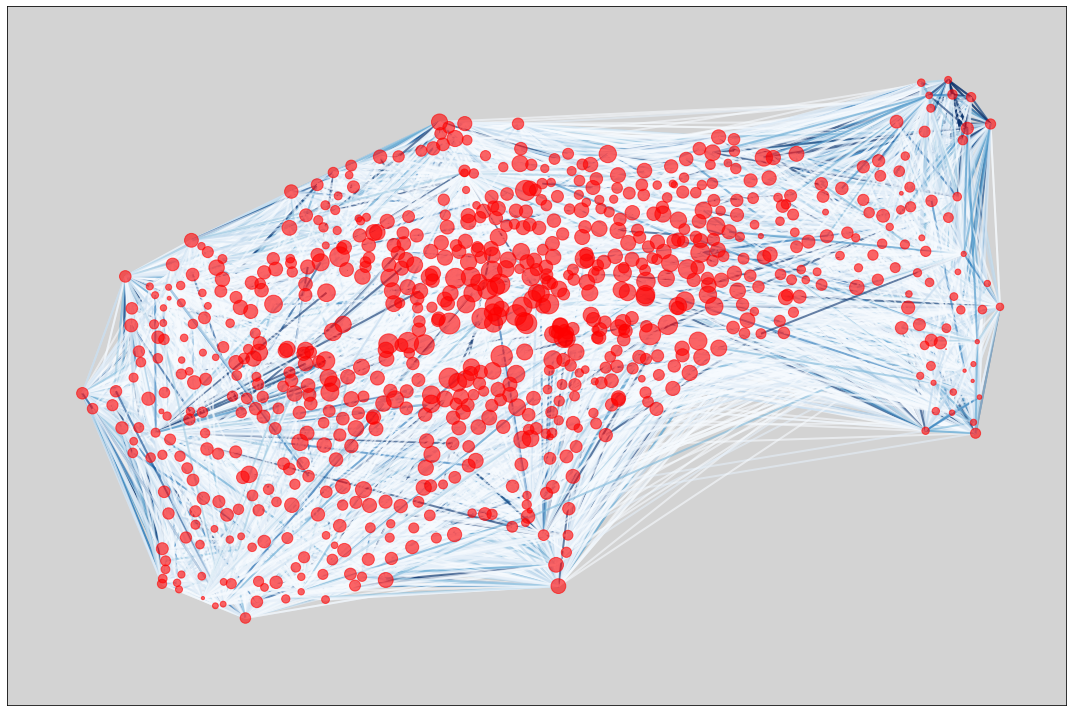

In [36]:
#COMMUTER JOURNEY NETWORK

import matplotlib.pyplot as plt
import math

commuter_degrees = dict(commuter_graph.degree)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('lightgrey')
nx.draw_networkx_nodes(G = commuter_graph, pos = pos, node_list = commuter_graph.nodes(), node_size=[(v-31)*0.5 for v in commuter_degrees.values()], node_color = 'r', alpha = 0.6) 
commuter_edges,commuter_weights = zip(*nx.get_edge_attributes(commuter_graph,'count').items())
nx.draw_networkx_edges(G = commuter_graph, pos = pos, edge_color=commuter_weights, arrows = False, edge_cmap=plt.cm.Blues, edge_vmax = qc975, width = 2, alpha = 0.6)
plt.tight_layout()
plt.savefig('commuter_journeys.png')
plt.show()

In [186]:
commuter_out = list(commuter_graph.out_degree(commuter_graph.nodes()))
commuter_in = list(commuter_graph.in_degree(commuter_graph.nodes()))

In [193]:
commuter_out_df = pd.DataFrame(commuter_out, columns=['station_id', 'out_degree'])
commuter_in_df = pd.DataFrame(commuter_in, columns=['station_id', 'in_degree'])
commuter_in_df = commuter_in_df.merge(id_to_name, on='station_id', how='left')
commuter_out_df = commuter_out_df.merge(id_to_name, on='station_id', how='left')
commuter_in_df.drop([22, 327], inplace = True) #duplicate nodes
commuter_out_df.drop([22, 327], inplace = True)
commuter_in_df.sort_values(by=['in_degree'], ascending=False).head(10)

station_id  in_degree                     station_name
86          541        485      Green Park Station, Mayfair
111         762        477       Storey's Gate, Westminster
39          194        476        Hop Exchange, The Borough
23          109        459                Soho Square, Soho
217         341        458            Craven Street, Strand
178         229        455          Whitehall Place, Strand
168         191        450      Hyde Park Corner, Hyde Park
177         228        447  St. James's Square, St. James's
172         213        441       Wellington Arch, Hyde Park
132          64        427        William IV Street, Strand

In [194]:
commuter_out_df.sort_values(by=['out_degree'], ascending=False).head(10)

station_id  out_degree                     station_name
111         762         469       Storey's Gate, Westminster
39          194         443        Hop Exchange, The Borough
23          109         437                Soho Square, Soho
328          14         432    Belgrove Street, King's Cross
168         191         431      Hyde Park Corner, Hyde Park
217         341         429            Craven Street, Strand
323         826         428       Allington Street, Victoria
86          541         424      Green Park Station, Mayfair
51          290         421      Winsland Street, Paddington
177         228         414  St. James's Square, St. James's

In [223]:
commuter_graph_ud = commuter_graph.to_undirected()
print (nx.average_clustering(commuter_graph_ud))

0.5243924644370558


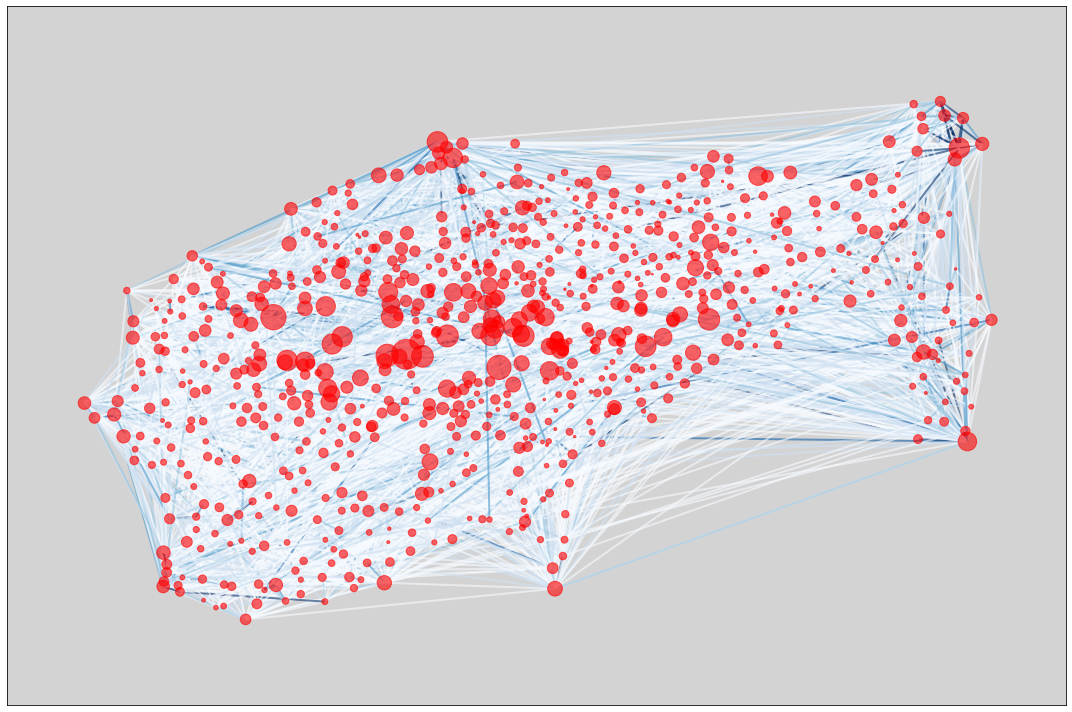

In [37]:
#LONG JOURNEY NETWORK

import matplotlib.pyplot as plt
import math

long_degrees = dict(long_graph.degree)


fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('lightgrey')
nx.draw_networkx_nodes(G = long_graph, pos = pos, node_list = long_graph.nodes(), node_size=[(v-1)*3 for v in long_degrees.values()], node_color = 'r', alpha = 0.6) 
long_edges,long_weights = zip(*nx.get_edge_attributes(long_graph,'count').items())
nx.draw_networkx_edges(G = long_graph, pos = pos, edge_color=long_weights, arrows = False, edge_cmap=plt.cm.Blues, edge_vmax = ql975, width = 2, alpha = 0.6)
plt.tight_layout()
plt.savefig('long_journeys.png')
plt.show()

In [195]:
long_out = list(long_graph.out_degree(long_graph.nodes()))
long_in = list(long_graph.in_degree(long_graph.nodes()))

In [198]:
long_out_df = pd.DataFrame(long_out, columns=['station_id', 'out_degree'])
long_in_df = pd.DataFrame(long_in, columns=['station_id', 'in_degree'])
long_in_df = long_in_df.merge(id_to_name, on='station_id', how='left')
long_out_df = long_out_df.merge(id_to_name, on='station_id', how='left')
long_in_df.drop(267, inplace = True) #duplicate nodes
long_out_df.drop(267, inplace = True)
long_in_df.sort_values(by=['in_degree'], ascending=False).head(10)

station_id  in_degree                         station_name
13          191        127          Hyde Park Corner, Hyde Park
71          762        115           Storey's Gate, Westminster
24          307         95  Black Lion Gate, Kensington Gardens
66          541         84          Green Park Station, Mayfair
268         130         83                 Tower Gardens, Tower
14          194         82            Hop Exchange, The Borough
59          229         82              Whitehall Place, Strand
54           99         77        Old Quebec Street, Marylebone
106         457         76        Castlehaven Road, Camden Town
238         341         75                Craven Street, Strand

In [199]:
commuter_out_df.sort_values(by=['out_degree'], ascending=False).head(10)

station_id  out_degree                     station_name
111         762         469       Storey's Gate, Westminster
39          194         443        Hop Exchange, The Borough
23          109         437                Soho Square, Soho
328          14         432    Belgrove Street, King's Cross
168         191         431      Hyde Park Corner, Hyde Park
217         341         429            Craven Street, Strand
323         826         428       Allington Street, Victoria
86          541         424      Green Park Station, Mayfair
51          290         421      Winsland Street, Paddington
177         228         414  St. James's Square, St. James's

In [222]:
long_graph_ud = long_graph.to_undirected()
print (nx.average_clustering(long_graph_ud))

0.14385485188898284


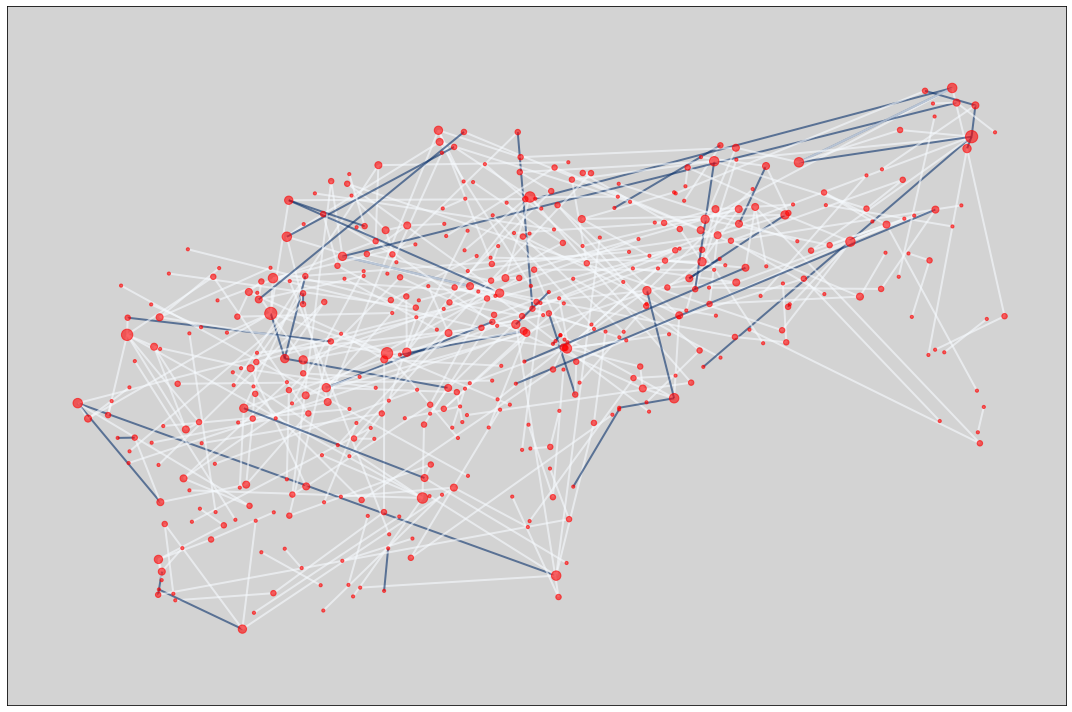

In [38]:
#DAY JOURNEY NETWORK

import matplotlib.pyplot as plt
import math

day_degrees = dict(day_graph.degree)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('lightgrey')
nx.draw_networkx_nodes(G = day_graph, pos = pos, node_list = day_graph.nodes(), node_size=[(v-0.5)*20 for v in day_degrees.values()], node_color = 'r', alpha = 0.6) 
day_edges,day_weights = zip(*nx.get_edge_attributes(day_graph,'count').items())
nx.draw_networkx_edges(G = day_graph, pos = pos, edge_color=day_weights, arrows = False, edge_cmap=plt.cm.Blues, edge_vmax = qd975, width=2, alpha = 0.6)
plt.tight_layout()
plt.savefig('day_journeys.png')
plt.show()

In [200]:
day_out = list(day_graph.out_degree(day_graph.nodes()))
day_in = list(day_graph.in_degree(day_graph.nodes()))

In [203]:
day_out_df = pd.DataFrame(day_out, columns=['station_id', 'out_degree'])
day_in_df = pd.DataFrame(day_in, columns=['station_id', 'in_degree'])
day_in_df = day_in_df.merge(id_to_name, on='station_id', how='left')
day_out_df = day_out_df.merge(id_to_name, on='station_id', how='left')
day_in_df.drop(204, inplace = True) #duplicate nodes
day_out_df.drop(204, inplace = True)
day_in_df.sort_values(by=['in_degree'], ascending=False).head(10)

station_id  in_degree                               station_name
3           154          4               Waterloo Station 3, Waterloo
205         717          4                   Dunston Road, Haggerston
71          568          4       Bishop's Bridge Road West, Bayswater
8             8          4                     Maida Vale, Maida Vale
191         798          4            Birkenhead Street, King's Cross
145         432          4  Exhibition Road Museums, South Kensington
232         753          3         Hammersmith Town Hall, Hammersmith
118         404          3            Palace Gate, Kensington Gardens
147         191          3                Hyde Park Corner, Hyde Park
108         479          3                 Pott Street, Bethnal Green

In [204]:
day_out_df.sort_values(by=['out_degree'], ascending=False).head(10)

station_id  out_degree                                  station_name
228         307           7           Black Lion Gate, Kensington Gardens
226         303           7                        Albert Gate, Hyde Park
354         591           6     Westfield Library Corner, Shepherd's Bush
57          785           6  Aquatic Centre, Queen Elizabeth Olympic Park
1           625           4                Queen's Circus, Battersea Park
38          832           3                      Ferndale Road, Brixton. 
368         668           3         Ravenscourt Park Station, Hammersmith
245         329           3         Prince Albert Road, The Regent's Park
381         631           3                Battersea Park Road, Nine Elms
277         386           3                             Moor Street, Soho

In [224]:
day_graph_ud = day_graph.to_undirected()
print (nx.average_clustering(day_graph_ud))

0.005857898715041571


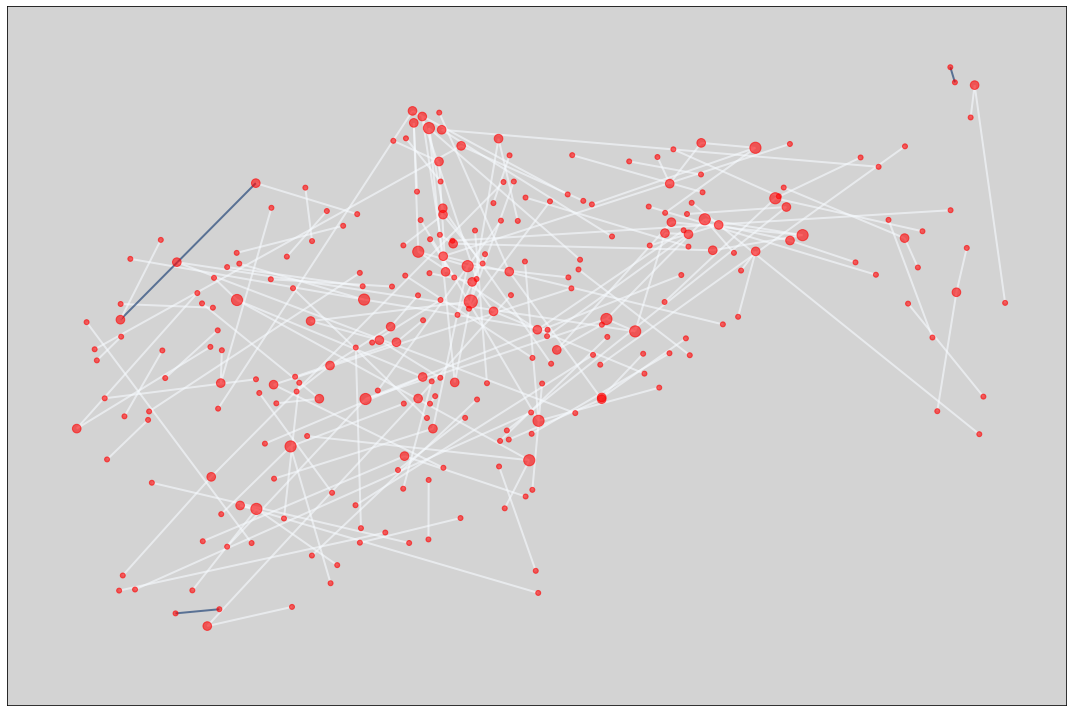

In [39]:
#MULTIDAY JOURNEY NETWORK

import matplotlib.pyplot as plt
import math

multiday_degrees = dict(multiday_graph.degree)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('lightgrey')
nx.draw_networkx_nodes(G = multiday_graph, pos = pos, node_list = multiday_graph.nodes(), node_size=[(v-0.5)*50 for v in multiday_degrees.values()], node_color = 'r', alpha = 0.6) 
multiday_edges,multiday_weights = zip(*nx.get_edge_attributes(multiday_graph,'count').items())
nx.draw_networkx_edges(G = multiday_graph, pos = pos, edge_color=multiday_weights, arrows = False, edge_cmap=plt.cm.Blues, edge_vmax = 2, width = 2, alpha = 0.6)
plt.tight_layout()
plt.savefig('multiday_journeys.png')
plt.show()

In [205]:
multiday_out = list(multiday_graph.out_degree(multiday_graph.nodes()))
multiday_in = list(multiday_graph.in_degree(multiday_graph.nodes()))

In [206]:
multiday_out_df = pd.DataFrame(multiday_out, columns=['station_id', 'out_degree'])
multiday_in_df = pd.DataFrame(multiday_in, columns=['station_id', 'in_degree'])
multiday_in_df = multiday_in_df.merge(id_to_name, on='station_id', how='left')
multiday_out_df = multiday_out_df.merge(id_to_name, on='station_id', how='left')
multiday_in_df.sort_values(by=['in_degree'], ascending=False).head(10)

station_id  in_degree                              station_name
71          503          3                    Cleveland Way, Stepney
26           86          3                 Sancroft Street, Vauxhall
258         378          2  Natural History Museum, South Kensington
223         780          2         Imperial Wharf Station, Sands End
30          717          2                  Dunston Road, Haggerston
60          185          2                  Alderney Street, Pimlico
23          409          2                 Strata, Elephant & Castle
43          444          2       Bethnal Green Garden, Bethnal Green
136         654          2                      Ashmole Estate, Oval
74          155          2                Lexham Gardens, Kensington

In [204]:
multiday_out_df.sort_values(by=['out_degree'], ascending=False).head(10)

station_id  out_degree                                  station_name
228         307           7           Black Lion Gate, Kensington Gardens
226         303           7                        Albert Gate, Hyde Park
354         591           6     Westfield Library Corner, Shepherd's Bush
57          785           6  Aquatic Centre, Queen Elizabeth Olympic Park
1           625           4                Queen's Circus, Battersea Park
38          832           3                      Ferndale Road, Brixton. 
368         668           3         Ravenscourt Park Station, Hammersmith
245         329           3         Prince Albert Road, The Regent's Park
381         631           3                Battersea Park Road, Nine Elms
277         386           3                             Moor Street, Soho

In [225]:
multiday_graph_ud = multiday_graph.to_undirected()
print (nx.average_clustering(multiday_graph_ud))

0.0
